[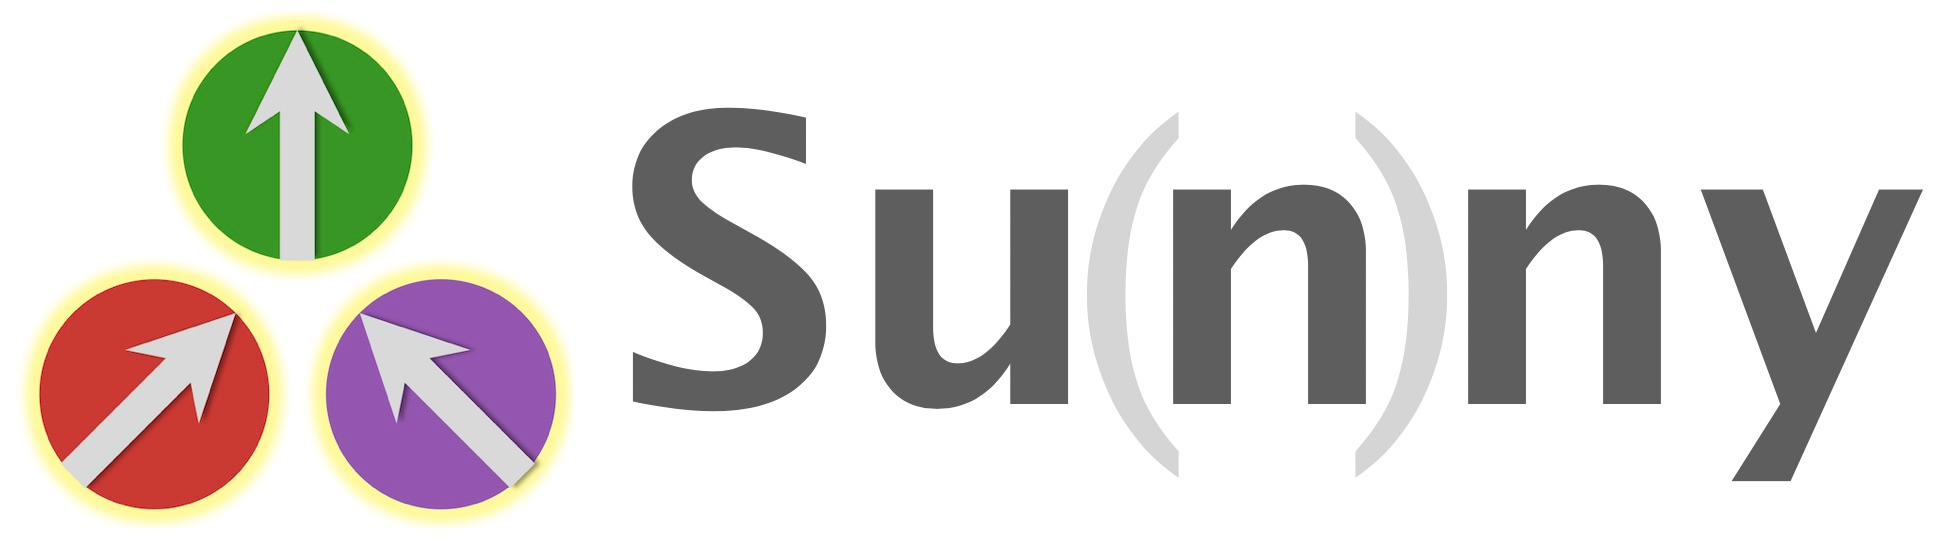](https://github.com/SunnySuite/Sunny.jl/)

_This is a tutorial for the [Sunny](https://github.com/SunnySuite/Sunny.jl/) package, which enables dynamical simulations of spins with dipole and higher order moments._

# SU(3) Case Study: FeI$_{2}$

**VERSION REQUIREMENTS** This tutorial requires Sunny v0.4 or to greater execute properly.

In this tutorial, we will walk through the process of calculating the dynamical properties of the compound FeI$_2$. This is an effective spin 1 material with strong single-ion anisotropy, making it an excellent candidate for treatment with generalized SU(3) spin dynamics.  In particular, the excitations of the system can only be captured classically with an SU(3) treatment. One magnon, clearly visible in the experimental data, would simply be absent if we were to employ traditional Landau-Lifshitz dynamics or SU(2) spin wave theory. Full details about the model can be found in reference [\[1\]](https://doi.org/10.1038/s41567-020-01110-1).

The model that we will be studying consists of a number of competing, anisotropic exchange interactions and a strong single-ion anisotropy term. Writing the exchange interactions in the most general way, the Hamiltonian simply has the form:

$\mathcal{H} = \sum_{\left(i,j\right)}J_{ij}\mathbf{S}_i\cdot\mathbf{S}_j - D\sum_i \left(S_i^z\right)^2$

We will begin by implementing this Hamiltonian in Sunny. To get started, we will import all the necessary Julia packages. The plotting packages may take a minute to load. Once imported, things will go more quickly. If you see an error "Package X not found in current path", you can install the package X by entering `using Pkg; pkg"add X"`.

In [1]:
using Sunny, Formatting, GLMakie, Random, JLD2
import Plots

┌ Info: Precompiling Sunny [2b4a2ac8-8f8b-43e8-abf4-3cb0c45e8736]
└ @ Base loading.jl:1662
┌ Info: Precompiling GLMakie [e9467ef8-e4e7-5192-8a1a-b1aee30e663a]
└ @ Base loading.jl:1662


This command will inject Javscript code into the Jupyter notebook to allow the crystal viewer to work without an internet connection.

In [2]:
Sunny.offline_viewers()

SunnyViewer(...)

## Setting up the Crystal

Sunny has a number of facilities for specifying a crystal. If a CIF file is available, it can be loaded using `Crystal("file.cif")`. Here, instead, we will directly specify the lattice vectors and atom positions for a unit cell.

In [3]:
a = b = 4.05012  # angstroms
c = 6.75214
lat_vecs = lattice_vectors(a, b, c, 90, 90, 120) # This a convenience method. Alternatively,
                                                 # lattice vectors could be specified as
                                                 # columns of a 3x3 matrix.
types = ["Fe", "I", "I"]
basis_vecs = [[0,0,0], [1/3, 2/3, 1/4], [2/3, 1/3, 3/4]] # Locations of atoms as multiples of lattice vectors

cryst = Crystal(lat_vecs, basis_vecs; types)

Crystal
HM symbol 'P -3 m 1' (164)
Lattice params a=4.05, b=4.05, c=6.752, α=90°, β=90°, γ=120°
Cell volume 95.92
Type 'Fe', Wyckoff 1a (point group '-3m.'):
   1. [0, 0, 0]
Type 'I', Wyckoff 2d (point group '3m.'):
   2. [0.3333, 0.6667, 0.25]
   3. [0.6667, 0.3333, 0.75]


Observe that Sunny inferred the space group `'P -3 m 1'`, corresponding to the international number 164. This is consistent with the table below, taken from reference [1]. Specifying the atom types can sometimes be necessary for Sunny to correctly infer the spacegroup symmetry.

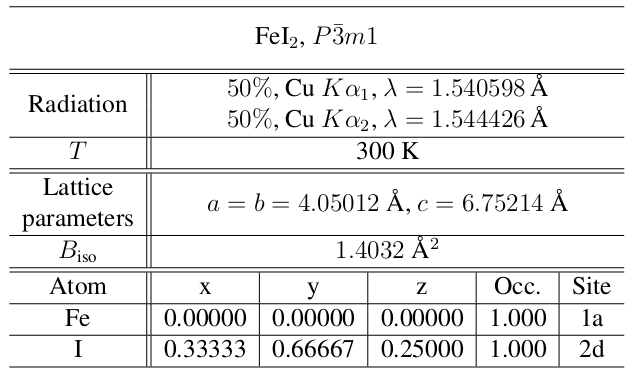

Alternatively, a `Crystal` can be constructed from a given spacegroup, here 164. The second I position will be inferred from the first one by symmetry.

In [4]:
types = ["Fe", "I"]
basis_vecs = [[0,0,0], [1/3, 2/3, 1/4]] # Locations of atoms as multiples of lattice vectors

cryst = Crystal(lat_vecs, basis_vecs, 164; types)

Crystal
HM symbol 'P -3 m 1' (164)
Lattice params a=4.05, b=4.05, c=6.752, α=90°, β=90°, γ=120°
Cell volume 95.92
Type 'Fe', Wyckoff 1a (point group '-3m.'):
   1. [0, 0, 0]
Type 'I', Wyckoff 2d (point group '3m.'):
   2. [0.3333, 0.6667, 0.25]
   3. [0.6667, 0.3333, 0.75]


## 3D Visualization

Sunny provides an interactive tool to visualize the 3D crystal structure, as well as the equivalence classes of "bonds."

In [5]:
view_crystal(cryst, 8.0)  # Second argument is maximum distance

SunnyViewer(...)

Dragging the mouse will rotate the crystal. Shift-dragging will translate. Spinning the mouse wheel (i.e., the window scroll action) will zoom.

Unselect the I checkbox to focus only on the Fe ions. We see that there are four equivalence classes of bonds between Fe ions within the specified radius of 8 Å.

The crystal viewer will be useful in conjunction with specifying interactions between bonds, as described below.

## Specifying Interactions

We now wish to implement the various interactions in the Hamiltonian given in reference [1]. These include 6 different anisotropic exchange interactions as well as a single-ion anisotropy. Each of these interactions must be assigned to a particular bond or particular site of the crystal. Note that it is necessary to specify an interaction only once on a single instance of a bond or site.  Sunny will automatically propagate the interaction to all other symmetry equivalent bonds or sites.

### Exchange interactions
The different bonds on which we wish to specify exchange interactions are illustrated with yellow arrows in the the following illustration \[1\]:


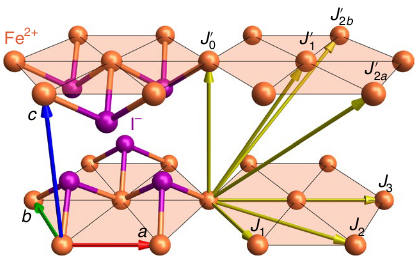

Correctly specifying these six interactions requires some care. Fortunately, Sunny provides tools to help.

Our interest is the magnetic behavior of the Fe ions. We will first restrict to this sublattice, while preserving spacegroup for the full FeI$_2$ crystal.

In [6]:
FeI2_cryst = subcrystal(cryst, "Fe")

Crystal
HM symbol 'P -3 m 1' (164)
Lattice params a=4.05, b=4.05, c=6.752, α=90°, β=90°, γ=120°
Cell volume 95.92
Type 'Fe', Wyckoff 1a (point group '-3m.'):
   1. [0, 0, 0]


Like SpinW, Sunny can perform a symmetry analysis, listing both the symmetry-allowed interactions for a representative set of bonds up to some maximum cutoff distance as well as symmetry allowed g-factors and anisotropies for each unique site.

In [7]:
print_symmetry_table(FeI2_cryst, 10.0)

Site 1
Type 'Fe', position [0, 0, 0], multiplicity 1
Allowed g-tensor: | A  0  0 |
                  | 0  A  0 |
                  | 0  0  B |
Allowed anisotropy in Stevens operators 𝒪[k,q]:
    c₁*𝒪[2,0] +
    c₂*𝒪[4,-3] + c₃*𝒪[4,0] +
    c₄*𝒪[6,-3] + c₅*𝒪[6,0] + c₆*𝒪[6,6]

Bond(1, 1, [1, 0, 0])
Distance 4.05012, coordination 6
Connects 'Fe' at [0, 0, 0] to 'Fe' at [1, 0, 0]
Allowed exchange matrix: | A  0  0 |
                         | 0  B  D |
                         | 0  D  C |

Bond(1, 1, [0, 0, 1])
Distance 6.75214, coordination 2
Connects 'Fe' at [0, 0, 0] to 'Fe' at [0, 0, 1]
Allowed exchange matrix: | A  0  0 |
                         | 0  A  0 |
                         | 0  0  B |

Bond(1, 1, [1, 2, 0])
Distance 7.01501361675086, coordination 6
Connects 'Fe' at [0, 0, 0] to 'Fe' at [1, 2, 0]
Allowed exchange matrix: | A  0  0 |
                         | 0  B  D |
                         | 0  D  C |

Bond(1, 1, [1, 0, 1])
Distance 7.8736818956572, coordination 12
Connec

Sunny has provided us with a great deal of useful information here, and it is worth dissecting the results.

At the very top of the list, Sunny provides the allowed form of a g-tensor for each site, as well as the general form of any permissible single site anisotropy. The latter is given in terms of a linear combination of Stevens operators. We will return to this information later. Let's move on to the exchange interactions.

The precise syntax for specifying a bond is given in bold at the top of each entry, e.g., `Bond(1, 1, [1, 0, 0])`. The first two arguments specify a pair of sites with an implied orientation (_from_ the first ion _to_ the second). The sites of ions are numbered according to the list provide when making a crystal. Since our cyrstal only contains a single site per unit cell -- the Fe ion -- the first two arguments to `Bond` will always be 1. The list provided as the final argument to `Bond` specifies an offset in terms of lattice vectors. So `Bond(1, 1, [1, 0, 0])` refers to the bond between the same ion in two different unit cells, specifically the unit cell that is offset one `a` lattice vector from the origin.

The length of the bond is given by `Distance`, which is useful for determining different orders of nearest neighbor. The coordinates of both the origin and destination of the bond are given in fractional coordinates. Finally, we should note that Sunny provides the allowed form of any exchange matrix that is assigned to the bond. If you try to give Sunny an exchange matrix that does not match this form, it will not allow you to build your model.

It is of course possible to work through the bond table and establish a correspondence between different bonds and the figure provided in the paper. For example, we can see that `Bond(1, 1, [1, 0, 0])` refers to $J_1$ in the illustration, since it is the shortest in-plane bond in the table. However, the crystal viewer introduced above can be a great aid in this process, and we encourage the reader to experiment with the viewer to establish correspondences with the information in the bond table. For example, selecting all the `J1` bonds in the crystal viewer will make the hexagonal unit from illustration \[1\] clearly visible.

The most general function for creating an exchange interaction is `exchange(J, bond)`, where `J` is a 3x3 exchange matrix, and `bond` follows the format of `print_symmetry_table()`. For example, nearest neighbor interactions can be specified using `exch1 = exchange(J, Bond(1, 1, [1, 0, 0]))`. 

We follow this procedure below, assigning the exchange matrices provided in reference [1] to their corresponding bonds in our crystal. We encourage the reader to go through this exercise independently, but the final result is below.

In [8]:
# ---------- Parameters as given in supplementary information ---------- #
J1pm   = -0.236
J1pmpm = -0.161
J1zpm  = -0.261

J2pm   = 0.026

J3pm   = 0.166

J′0pm  = 0.037

J′1pm  = 0.013

J′2apm = 0.068
D      = 2.165

J1zz   = -0.236
J2zz   = 0.113
J3zz   = 0.211
J′0zz  = -0.036
J′1zz  = 0.051
J′2azz = 0.073
J′2bzz = 0.0

# ---------- Parameters transformed into exchange matrices ---------- #
J1xx = J1pm + J1pmpm 
J1yy = J1pm - J1pmpm
J1yz = J1zpm

J₁ = [J1xx  0.0   0.0;
      0.0   J1yy  J1yz;
      0.0   J1yz  J1zz]

J₂ = [J2pm  0.0  0.0;
      0.0   J2pm 0.0;
      0.0   0.0  J2zz]

J₃ = [J3pm   0.0   0.0;
      0.0    J3pm  0.0;
      0.0    0.0   J3zz]

J′₀ = [J′0pm  0.0   0.0;
       0.0    J′0pm 0.0;
       0.0    0.0   J′0zz]

J′₁ = [J′1pm  0.0   0.0;
       0.0    J′1pm 0.0;
       0.0    0.0   J′1zz]

J′₂ = [J′2apm  0.0   0.0;
       0.0    J′2apm 0.0;
       0.0    0.0   J′2azz]


exchange_interactions = [
      exchange(J₁, Bond(1,1,[1,0,0])),
      exchange(J₂, Bond(1,1,[1,2,0])),
      exchange(J₃, Bond(1,1,[2,0,0])),
      exchange(J′₀, Bond(1,1,[0,0,1])),
      exchange(J′₁, Bond(1,1,[1,0,1])),
      exchange(J′₂, Bond(1,1,[1,2,1])),
];

### Onsite Anistropy

In addition to the exchange interactions specified above, the model includes a strong single-ion anisotropy term: $D\left(\hat{S}^z\right)^2$. Sunny allows the user to specify the anisotropy directly in this form, as it would appear in the quantum Hamiltonian. For this purpose Sunny provides the symbols 𝒮[1], 𝒮[2], 𝒮[3], corresponding to the x, y, and z spin operators. To specify the anisotropy, simply call `anisotropy` and provide a polynomial in terms of these symbols together with information about the site to which the anisotropy will be assigned.

In [9]:
D = -2.165
Sz2 = 𝒮[3]^2
aniso = anisotropy(D*Sz2, 1, "anisotropy")

Sunny.OperatorAnisotropy(-2.165𝒮₃², 1, "anisotropy")

When we instantiate our model, Sunny will automatically analyze this anisotropy to ensure it does not violate the symmetry properties of the crystal to which it is assigned.

In this case, we know that the anisotropy is valid and expect Sunny to accept it without complaint. Suppose we didn't know this in advance. Recall when we called `print_symmery_table`, at the top of the report we got anisotropy information. Let's do so again, this time setting the radius of interest to 0 (since we're only concerned with one site).

In [10]:
print_symmetry_table(FeI2_cryst, 0)

Site 1
Type 'Fe', position [0, 0, 0], multiplicity 1
Allowed g-tensor: | A  0  0 |
                  | 0  A  0 |
                  | 0  0  B |
Allowed anisotropy in Stevens operators 𝒪[k,q]:
    c₁*𝒪[2,0] +
    c₂*𝒪[4,-3] + c₃*𝒪[4,0] +
    c₄*𝒪[6,-3] + c₅*𝒪[6,0] + c₆*𝒪[6,6]



Sunny here shows us the valid anisotropies expressed in terms of Stevens operators. Stevens operators are a set of basis functions similar to spherical harmonics. (Specifically, they are symmetrized spherical tensor operators). Like spherical harmonics, they are specified with two numbers, which we will call $k$ and $q$: $\mathcal{O}_{k,q}$. For any $k$, $q$ takes values in the range $-k \leq q \leq k$. As with the spin operators, Sunny provides symbols for the Stevens operators. For example, to specify the k=2, q=0 operator, simply write:

In [11]:
𝒪[2,0]

𝒪₂₀

We specified an anisotropy proportional to 𝒮₃². To find an equivalent expression in terms of Stevens operators, we can use `print_anisotropy_as_stevens`:

In [12]:
print_anisotropy_as_stevens(𝒮[3]^2; N=3)

(1/3)𝒪₂₀ + 2/3


This is in the form $c₁*𝒪[2,0]$, plus an irrelevant constant shift, which is allowed according to the symmetry analysis. So we could have specified the anisotropy as:

In [13]:
equivalent_aniso = anisotropy((D/3)*𝒪[2,0], 1, "equivalent_anisotropy")

Sunny.OperatorAnisotropy(-0.7216666666666667𝒪₂₀, 1, "equivalent_anisotropy")

## Building a `SpinSystem`

All of the information we have specified above is tied together in a `SpinSystem`. A `SpinSystem` is created by providing a crystal, a list of interactions, lattice dimensions, and, optionally, a list of `SiteInfo`s. We have already made our crystal and specified our interactions, and we may choose any dimensions we like. `SiteInfo(i; N=0, g=2*I(3), spin_rescaling=1.0)` allows us to specify additional information that applies only to individual ions within the unit cell. Its keyword arguments are the following: `N` determines the complex dimension of our generalized SU(_N_) spin; `g` is the g-tensor; and `spin_rescaling` determines and arbitrary rescaling of the spin on the specified site. Note that the default setting of `N=0` corresponds to working with traditional, classical spins, i.e. real, 3-component vectors representing magnetic dipole moments. For this example, we wish to use SU(3) generalized spins and will correspondingly set `N=3`.

In [14]:
site_infos = [SiteInfo(1; N=3, ff_elem="Fe2", ff_lande=3/2)];

Note that we have provided Sunny with some additional keywords giving more information about the magnetic ion. If provided, this information will be used to apply form factor corrections to any dynamic structure factor you may later calculate.

After specifying lattice dimensions and assembling our interactions into a single list, we can build our model.

In [15]:
dims = (4, 4, 4)
interactions = [exchange_interactions; aniso]

rng = MersenneTwister(112)
sys = SpinSystem(FeI2_cryst, interactions, dims, site_infos; rng);

And we have our SU(3) `SpinSystem`!

In the process of creating our `SpinSystem`, Sunny has checked the validity of all our interactions. Had we provided an exchange interaction or anisotropy that violated the symmetry properties of our crystal, it would have resulted in an error. You might find it a useful exercise to try to build a `SpinSystem` with symmetry-violating interactions.

With our `SpinSystem` in hand, we can begin performing calculations. 

## Finding a Ground State

In the remainder of this tutorial, we will go through the basic steps necessary to calculate a dynamical spin structure factor (DSSF) for FeI$_2$. Sunny provides some automated functionality for performing such calculations. See the official documentation [here](https://sunnysuite.github.io/Sunny.jl/dev/library/#Sunny.dynamic_structure_factor) and an example [here](https://sunnysuite.github.io/Sunny.jl/dev/examples/#Example-1:-Diamond-lattice-with-antiferromagnetic-Heisenberg-interactions). We will be able to make more effective use of Sunny's DSSF tools if we start the calculation with a ground state, and in this section we will present one approach to finding ground states. 

It is possible to formulate an Langevin equation for the classical SU(N) dynamics supported by Sunny, i.e., to perform dynamical simulations in the presence of a thermal bath. This is a very efficient approach to sampling states at finite temperatures and is one of Sunny's most powerful features. We can also use this feature to set up an annealing procedure and thereby use the integretor to solve our optimization problem.

### Langevin Sampler


Since Langevin sampling involves the simulation of dynamics, it is necessary to define a few parameters before building a sampler. In particular, we need a time step and a damping coefficient.

In [16]:
Δt  = abs(0.02 / D)  # Safe choice for integration step size, where the divisor is the largest coefficient in the Hamiltonian
α = 0.1;  # Damping coefficient, can be determined empirically

The sampler also has to know how long to run a simulation (number of updates) before offering up a sample. Based on past experience, we will choose a duration of 15 meV$^{-1}$.

In [17]:
sample_dur = 30.0
num_steps = round(Int, sample_dur/Δt);

Finally we need a temperature.

In [18]:
kT = 10.0; # meV

It is now possible to instantiate a `LangevinSampler`. 

In [19]:
langevin_sampler = LangevinSampler(sys, kT, α, Δt, num_steps);

Everytime we call `sample!(langevin_sampler)`, Sunny will simulate the dynamics of our model at `kT` for `num_steps`. 

With our sampler in hand, we will establish a very basic annealing protocol: sampling once at each temperature in a sequence of temperatures that descend geometrically from some high value. A simple function will help facilitate this calculation.

In [20]:
function anneal!(sampler, kTs)
      Es = zeros(length(kTs))        # Buffer for saving energy as we proceed

      for (i, kT) in enumerate(kTs)
            set_temp!(sampler, kT)
            sample!(sampler)                    # Sample from the system
            Es[i] = running_energy(sampler)   # Query the energy
      end
    
      return Es    # Return the energy values collected during annealing
end;

We can now perform the annealing procedure.  (This may take a minute.)

In [21]:
kTs = [kT * 0.9^k for k ∈ 0:100]
rand!(sys)   # Random initial conditions in the spin system (infinite temperature)
Es = anneal!(langevin_sampler, kTs; )

# Run for a final stretch at 0 temperature
set_temp!(langevin_sampler, 0.0)
@time for _ in 1:5
    sample!(langevin_sampler)
end

  0.625728 seconds (81.31 k allocations: 3.227 MiB, 0.80% compilation time)


Let's examine the energy curve we collected during the annealing process.

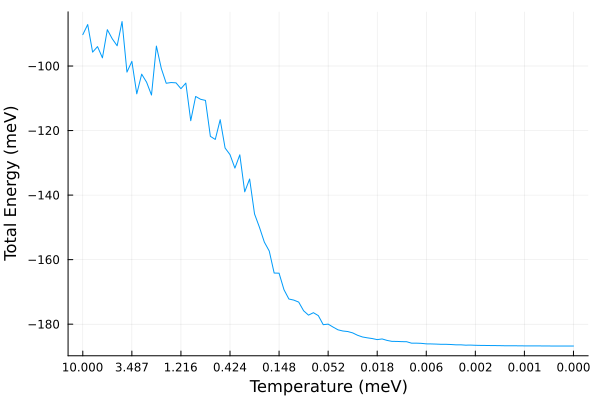

In [22]:
xtickvals = kTs[1:10:end]

Plots.plot(kTs, Es[end:-1:1];  xlabel="Temperature (meV)",
    ylabel="Total Energy (meV)", label=false, xscale=:log10, fmt=:png,
    xticks=(xtickvals, [format("{:.3f}", x) for x ∈ xtickvals][end:-1:1])
                
)

We seem to have reached at least a local mininimum.  The actual ground state for this material is known. It is a striped configurations. Each stripe is two spins wide, and the polarization of the stripes alternates. The axis of polarization is nearly the z-axis, but the spins are canted away from this axis slightly.

Let us take a look at the spin configuration that we have found to see if it matches this description. Sunny provides a function, `plot_spins`, for inspecting spin configurations. Note that it requires the `GLMakie` package. If run outside of the notebook environment, `plot_spins` will allow you to interactive zoom and pan.

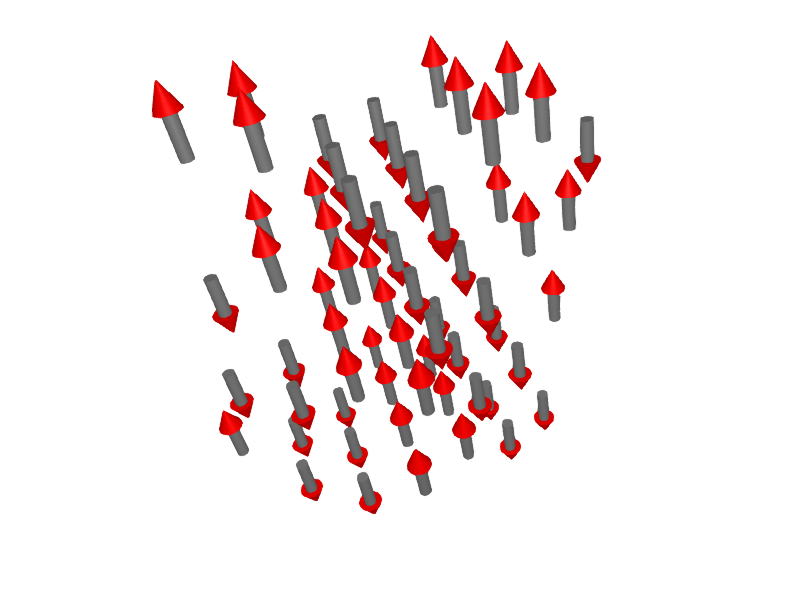

In [23]:
plot_spins(sys; arrowlength=2.5, linewidth=0.75, arrowsize=1.5)

Hopefully you see a result that matches the description given above. If not, try running a few times until you do. It's not uncommon to encounter domain formation. Sunny has a number of powerful tools for dealing with these situations, which you can learn about in forthcoming tutorials.

## Calculating a Dynamical Structure Factor

With our ground state in hand, we can begin performing the calculations to create a dynamical spin structure factor (DSSF).  This is useful for direct comparison with neutron scattering data.

Because Sunny performs calculations on a finite lattice, the resolution in momentum space will be limited by the size of the lattice. Specifically, along each axis $i$, we will get values at values of $Q_i = \frac{2\pi n}{L_i}$, where $n$ runs from $(\frac{-L_i}{2}+1)$ to $\frac{L_i}{2}$ and $L_i$ is the linear dimension of the lattice. We therefore would like to work with as large a system as possible in order to maximize our momentum space resolution.

The spin system we used above is quite small. This choice was made to accelerate the process of finding a ground state. The dimensions of the system were also selected so that they would be comensurate with the size of the magnetic unit cell, a choice that will allow us to simply be extend the system periodically to find a ground state of a larger system. The periodic extension can be accomplished with `extend_periodically(sf::SpinSystem, mults::NTuple{3, Int64})`. This function takes two arguments: your original spin system, and a tuple of integer multipliers to be applied to the size of the lattice along each axis. Because we are mostly interested in taking slices of the resulting structure factor along the $a^*$ and $b^*$ axis, we will only expand the size of our system along these two dimensions, in this case by a factor of 3.

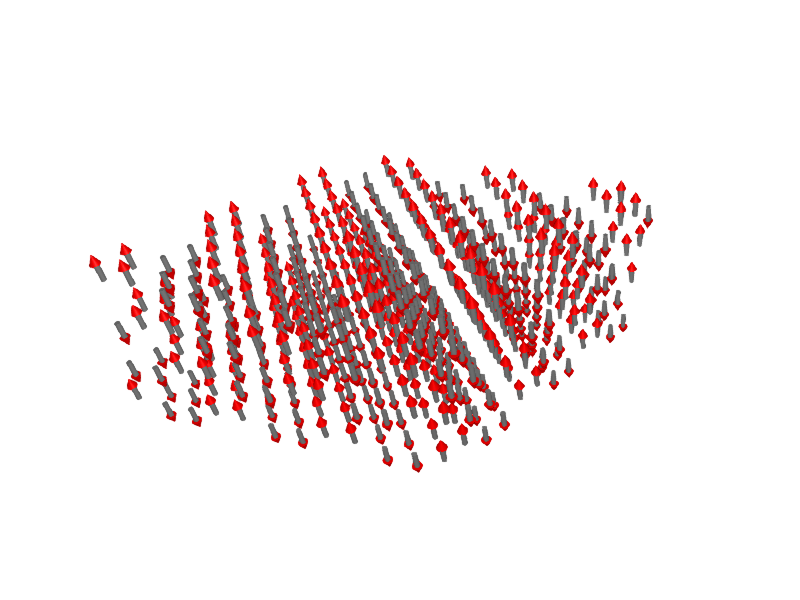

In [24]:
sys_big = extend_periodically(sys, (3, 3, 1)) 

plot_spins(sys_big; arrowlength=2.5, linewidth=0.75, arrowsize=1.5)

You should see a $12 \times 12 \times 4$ spin system in our striped ground state.

We will save this ground state for later usage with Julia's `JLD2` package.

In [25]:
save("FeI2_ground_state.jld2", "Zs", sys_big._coherents)

We are now in a position to calculate the dynamic structure factor. The basic procedure consists of the following steps: (1) thermalizing the system; (2) taking sample spin configurations at equilibrium; and (3) and using these samples as initial conditions for the calculation of dynamical trajectories. The structure factor can be then be calculated from the Fourier transforms of the trajectories. We do not intend to go into the details but instead show how to use Sunny's `dynamic_structure_factor` function to automate this process. We encourage you to read the details about this function by entering `? dynamic_structure_factor` in a Julia REPL (assuming Sunny has been imported into that REPL environment). 

While `dynamic_structure_factor` automates much of the calculation, some setup is still required of the user. We first examine the full function specification

```
function dynamic_structure_factor(sys::SpinSystem, sampler::S; 
    nsamples::Int=10, thermalize::Int=10, bz_size=(1,1,1),
    reduce_basis::Bool=true, dipole_factor::Bool=false,
    dt::Float64=0.01, num_omegas::Int=100, omega_max=nothing,
    ff_elem=nothing, lande=false, verbose::Bool=false
) where {S <: AbstractSampler}
```

The two mandatory arguments are `sys` and `sampler`. `sys` is simply a spin system. If finding the ground state of your system is difficult, and you are simulating at low temperatures, it is generally best if the spins in `sys` are already in a ground state. We have already prepared our `sys_big` this way.

 The `sampler` will be used to thermalize the system and generate samples at a specified temperature. We will set up a `LangevinSampler`, which is simply a Langevin integrator of the type we used above with some added functionalities, though you may use whatever sampler type you'd like. Currently Sunny also provides a `MetropolisSampler`, but you are free to implement your own.
 
We need to provide several arguments to create a sampler: `LangevinSampler(sys::SpinSystem, kT::Float64, α::Float64, Δt::Float64, nsteps::Int)`. `kT` is the temperature you would like to sample at (meV by default); `α` and `Δt` are the damping coefficient and step size for the Langevin integrator; and `nsteps` is the number of updates to perform between samples.

`nsteps` is an important parameter to set. It should be large enough to ensure that successively samples are decorrelated, but not longer than necessary, as this is directly related to simulation time. We will set this value based on prior experience with this model and discuss these issues in more detail in another tutorial.

In [26]:
decorr_time = 2.0 # Time in meV^-1 required to get an uncorrelated sample
nsteps = round(Int, decorr_time/Δt) # Number of time steps corresponding to this duration
kT = 0.5 * Sunny.meV_per_K # Temperature in meV

sampler = LangevinSampler(sys_big, kT, α, Δt, nsteps);

Now let's take a look at some of the other important parameters of `dynamic_structure_factor`. `dt` is the step size used by the integrator that will perform the generalized dynamics. Note that this integrator is different from the Langevin integrator, and it remains stable at much larger time steps. `omega_max` determines the highest energy that you wish to resolve in the simulation, given in units of meV. `num_omegas` determines how many energies to resolve between 0 and `omega_max`. `nsamples` is the number of dynamical trajectories to calculate, which corresponds to the number of samples that go into the creation of the final structure factor. At low temperature, only a few samples are required to get interpretable results.

`thermalize` is an integer corresponding to the number of times the sampler will be run before actually collecting samples. The best value will depend on the system you are studying. This model thermalizes well within 10.0 meV$^{-1}$, and we set the sampler to run for 2.0 meV$^{-1}$ between samples. Setting this to 5 or 6 should therefore be sufficient to thermalize our system.

`reduce_basis` can be set to `true` if you wish to perform phase-weighted averaging over the different sites in your crystallographic unit cell. If set to `false`, the resulting structure factor will have extra indices corresponding to each site in the unit cell. 

   `dipole_factor` can be set to true or false, depending on whether you wish to apply the magnetic dipole correction factor to the results. If set to true, the final structure factor will only have indices corresponding to the three directions in momentum space and energy.

Setting `verbose` to true will give you updates about the progress of the calculation.

With that out of the way, let's take it for a spin. This may take a minute or two on a typical laptop.

In [27]:
dt = 0.025 # Step size for generalized Landau-Lifshitz dynamics
omega_max = 8.0 # Maximum energy to resolve
num_omegas = 300 # Number of energies to resolve
nsamples = 10 # Number of samples used to calculate structure factor

dynsf = dynamic_structure_factor(sys_big, sampler;
    nsamples, dt, omega_max, num_omegas, thermalize = 6,
    verbose=true, reduce_basis=true, dipole_factor=true,
)

Beginning thermalization...
Done thermalizing. Beginning measurements...


Sample: 100%|███████████████████████████████████████████| Time: 0:00:38


12x12x4x300 StructureFactor

Our structure factor is now ready. If you wish to perform any other post-processing, the raw data can be accessed directly: `dynsf.sfactor`.

Sunny provides a simple function, `sf_slice`, for extracting paths from the structure factor. `sf_slice` takes two arguments: a `StructureFactor` (`dynsf` in our case), and a list of points in momentum space. It will return a two-dimensional array corresponding to a linear path between the given points.

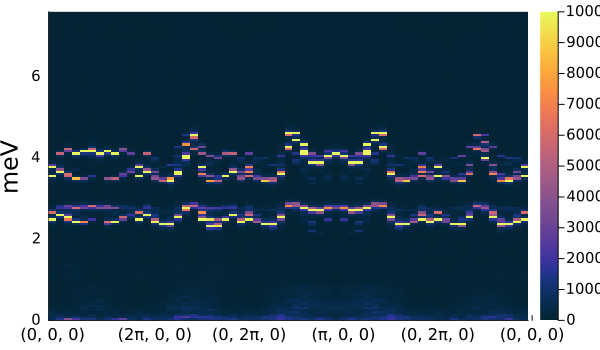

In [28]:
# Select a series of points in momentum space to define a path
points = [ [0.0, 0.0, 0.0],
           [1.0, 0.0, 0.0],
           [0.0, 1.0, 0.0],
           [0.5, 0.0, 0.0],
           [0.0, 1.0, 0.0],
           [0.0, 0.0, 0.0]] * 2π 

# Extract the path from the structure factor using the following keywords:
# return_idcs: return the indices corresponding to the path points
# interp_scale: how many more points to extract than would be possible without interpolation
(; slice, idcs) = sf_slice(dynsf, points; return_idcs=true, interp_scale=1)
                                                                        
# Determine plot label information
ωs = omega_labels(dynsf) # Get the energies associated with the ω indices
i = findfirst(x -> x > 7.5, ωs) # Only plot up to 7.5 meV
in_pi(x) = x ≈ 0 ? "0" : x ≈ π ? "π" : "$(round(Int,x/π))π" #For formatting the tick labels
xticklabels = map(x -> "($(in_pi(x[1])), $(in_pi(x[2])), $(in_pi(x[3])))", points) # Generate the tick labels

# Plot
Plots.heatmap(1:size(slice, 1), ωs[0:i], slice[:,0:i]';
    color=:thermal, clims=(0.0, 1.0e6), xticks=(idcs, xticklabels),
    xtickfontsize=11, ytickfontsize=10,
    ylabel="meV", ylabelfontsize=16, size=(600,350), fmt=:png
)

## Getting Publication Quality Results

The workflow described above is very useful for quickly getting results. For publication quality results, you will likely want to use a larger system and take many more samples. This may require substantially more computation. 

As an example, the image below was generated using a system of $24 \times 24 \times 8$ spins. A single sample will require 3-5 minutes of computation time. (You should try it out yourself by adapting the example above.) To get thousands of samples, it will naturally be very helpful to do as many of these calculations as possible at the same time. In the next section, we touch briefly on one approach to doing this.

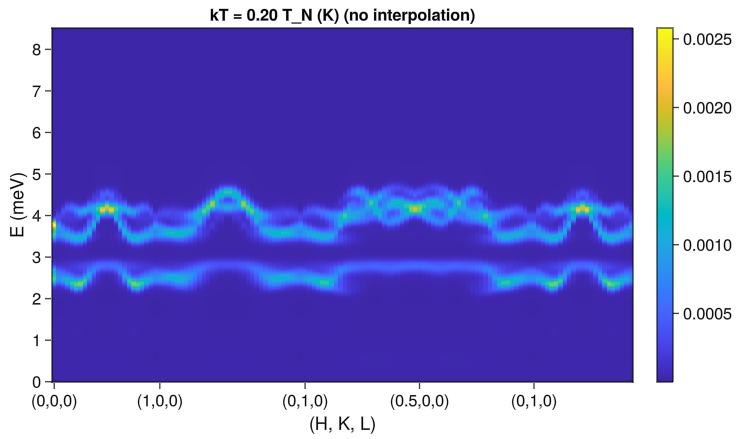

## Using Julia's Parallelism Capabilities

In this section, we briefly show how to achieve some parallelism on a single computer with multiple cores. Julia has a built-in distributed computing package called `Distributed`. We will begin by importing this package and adding several processes. The number added should be equal to the number of cores you have on your computer. Once added, each one of these processes will be available to perform computations simultaneously.

In [29]:
using Distributed
addprocs(8);

Julia now has access to 8 additional Julia environments just like the one we're using now for this example. We have to prepare each one of those Julia environment just as we did this one by importing the relevant packages. To do that, we use the macro `@everywhere` before importing the packages.

In [30]:
@everywhere using Sunny, LinearAlgebra, Random, JLD2

It is also necessary to use an `@everywhere` before the definition of every function we write that we wish to be able to use on the remote processes. To save time, the model definition above has been rewritten in a function called `FeI₂`, which we have saved in a file `model.jl`. We will import this function everywhere. After this, each one of the Julia processes can create an FeI2 spin system with a simple function call.

In [31]:
@everywhere include("model.jl")

A simple way to get these remote processes to do something is to use the `pmap` function. `pmap` takes a list of things you'd like to iterate over.  `pmap` will take each item from this list and pass it to a block of code. It will then look for available remote processes and try to execute the block of code there. If multiple processes are free, `pmap` will ask them to do their work at the same time. 

Here we will make a list of temperatures, one of which will be used on each process. The block of code that we will execute creates a spin system and a Langevin sampler, performs the calculation of a dynamic structure factor, and finally saves the results. It is a brief recapitulation of everything we did above.

If everything is working, you should find that the execution of this block of code does not take much longer than the calculation of a single structure factor.

In [32]:
T_N = 3.2
kTs = range(0.2, 1.17, length=(nprocs()-1)) .* T_N
seeds = 1:length(kTs)

pmap(zip(seeds, kTs)) do (seed, kT)
    rng = MersenneTwister(seed)
    
    # Create an FeI₂ system and initialize in ground state
    sys = FeI₂((12, 12, 4); rng)
    Zs = load("FeI2_ground_state.jld2", "Zs")
    Sunny.init_from_coherents!(sys, Zs)
    
    # Set up Langevin sampler
    decorr_time = 2.0 # Time in meV^-1 required to get an uncorrelated sample
    nsteps = round(Int, decorr_time/Δt) # Number of time steps corresponding to this duration
    kT *= Sunny.meV_per_K # Temperature in meV
    α = 0.1
    Δt_lang = 0.0092
    sampler = LangevinSampler(sys, kT, α, Δt_lang, nsteps);
    
    # Calculate the dynamic structure factor
    dt = 0.025 # Step size for generalized Landau-Lifshitz dynamics
    omega_max = 8.0 # Maximum energy to resolve
    num_omegas = 300 # Number of energies to resolve

    sf = dynamic_structure_factor(sys, sampler;
        dt, omega_max, num_omegas, thermalize = 6,
        verbose=false, reduce_basis=true, dipole_factor=true,
    )
    
    save("FeI2_dynsf_$(seed).jld2", "sf", sf)  
end;

We can now load the structure factors, pull out slices, and plot the results.

In [33]:
sfs = [load("FeI2_dynsf_$(seed).jld2", "sf") for seed in seeds]
slices = [sf_slice(sf, points; interp_scale=2) for sf in sfs];

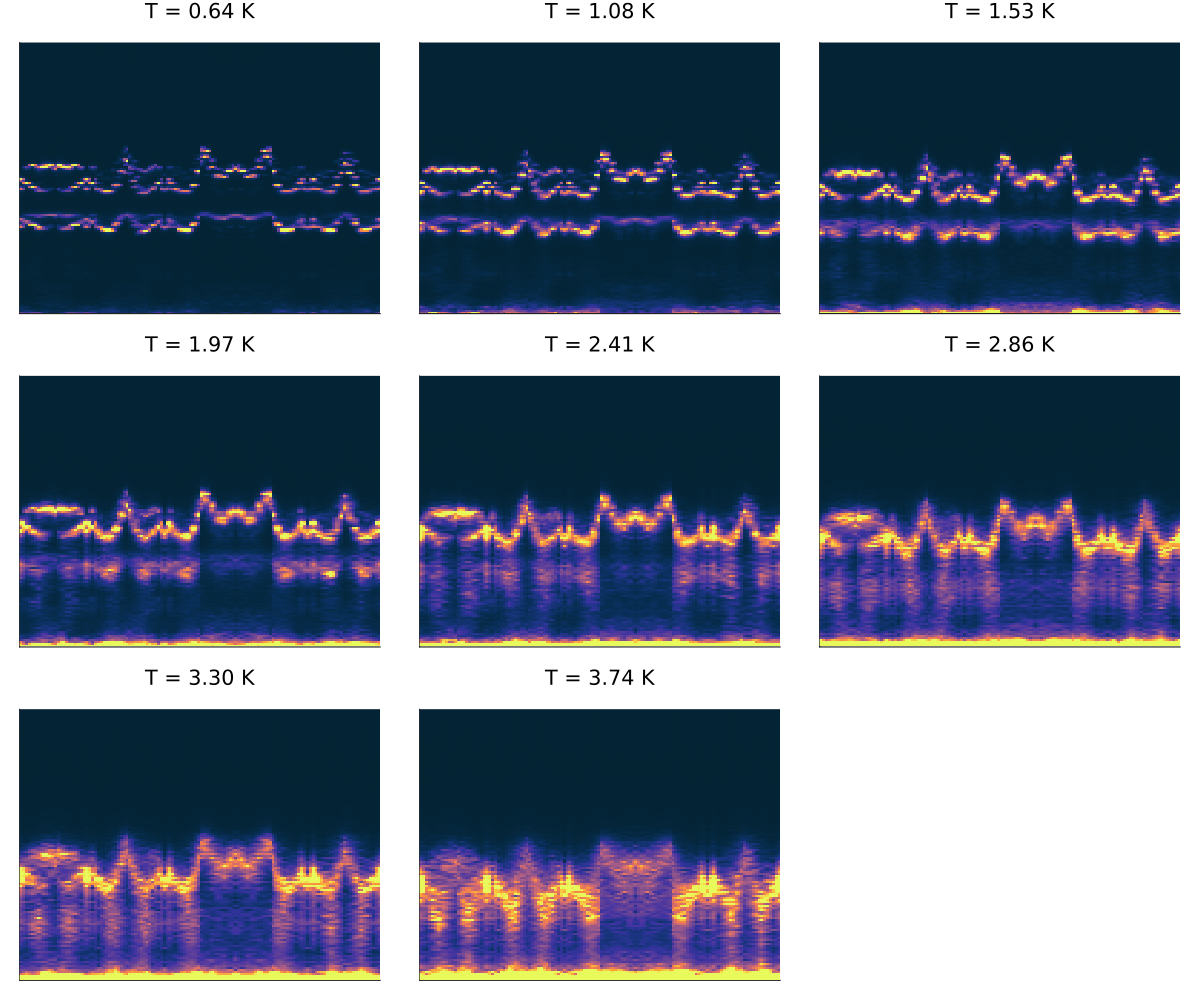

In [34]:
using Formatting

ps = []
for (slice, kT) in zip(slices, kTs)
    p = Plots.heatmap(1:size(slice, 1), ωs[0:i], slice[:,0:i]';
        color=:thermal, xticks=nothing, yticks=nothing, clims=(0.0, 5e6), colorbar=false,
        title="T = "*format("{:.2f} K", kT))
    push!(ps, p)
end

# layout = Plots.@layout [a; b; c; d; e; f; g; h]
Plots.plot(ps...; size=(1200,1000), margin=3Plots.mm, fmt=:png)

## References
\[1\] Bai et al., _Hybridized quadrupolar excitations in the spin-anisotropic frustrated magnet FeI2_, Nature Physics v. 17 (2021). (https://doi.org/10.1038/s41567-020-01110-1)

\[2\] Dahlbom et al., _Geometric integration of classical spin dynamics via a mean-field Schrödinger equation_ Physical Review B 106 (2022) (https://doi.org/10.1103/PhysRevB.106.054423).